# Manipulation de la librairie networkx

## Construction de réseaux d'interactions à partir de données MITAB.

Le format (MITAB) stocke des paires de protéines en interaction. Dans ce format, chaque colonne porte une information spécifique.
Une description du format est disponible [ici](https://psicquic.github.io/MITAB27Format.html).
Les données d'interactions impliquant les protéines surreprésentées de l'expérience ont été obtenues depuis la base de données [Intact](https://www.ebi.ac.uk/intact/home).
Ces données sont mises à votre disposition dans le fichier `data/proteins.mitab`.

Vous extrairez du fichier les paires d'identifiants uniprot des protéines en interaction.

Ces paires de protéines constituent un réseau d'interaction protéine-protéine que vous allez dessiner à l'aide de la libraire [networkx](https://networkx.org/documentation/stable/reference).
Le code suivant vous est fourni à titre d'exemple.

```python
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
G = nx.Graph()

fig, ax = plt.subplots(figsize=(8, 8))

G.add_edge('a', 'b')
G.add_edge('e', 'b')
G.add_edge('e', 'a')
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=['blue','blue','red'] , node_size=2000)
```


In [1]:
import pandas as pd
import numpy as np
import matplotlib
import math

data = pd.read_csv('../proteins.mitab', sep='\t', header=None)
data = data.dropna()

datatcl = pd.read_csv('../TCL_wt1.tsv', sep = '\t')
datatcl = datatcl.dropna()

- 2 premiers champs : interaction entre 2 protéines
- MI : molecular interaction
- identifiants alternatifs : issus par exemple d'entrées automatiques (Trembl)
- 2 premières colonnes ici seulement
- tuples
- enlever les id uniprot
- => structure de base pour fabriquer un réseau

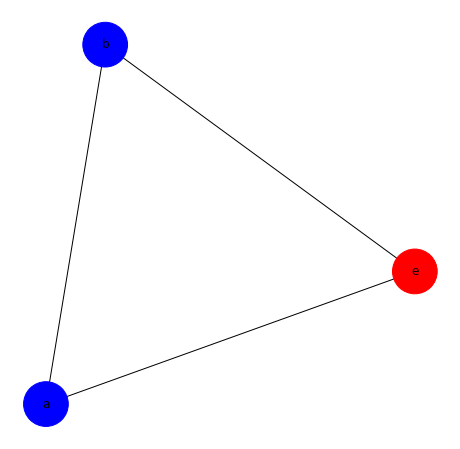

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
G = nx.Graph()

fig, ax = plt.subplots(figsize=(8, 8)) # ax pour contrôler la taille de la figure

#G.add_edge('a', 'b', weight=3)

G.add_edge('a', 'b')
G.add_edge('e', 'b')
G.add_edge('e', 'a')
pos = nx.spring_layout(G) # layout : calcule la position des noeuds
#nx.draw(G, pos)
nx.draw(G, pos, with_labels=True, node_color=['blue','blue','red'] , node_size=2000)

Les positions des noeuds sont paramétrables au travers de l'objet [layout](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html). Une fois une première représentation du réseau obtenue, affinez celle-ci afin de:

* Écrire les identifiants uniprot dans les noeuds du réseau.
* Faire du diamètre des noeuds une fonction du nombre de partenaires protéiques.
* Faire de la largeur des arêtes une fonction du nombre d'experiences (lignes MITAB) detectant cette interaction
* Colorier les arêtes soutenues par au moins une interaction de type physique entre proteines.


In [3]:
class Protein:
    def __init__(self, pid):
        self.pid = pid
        self.interactions = []
    def add_interaction(self, pid):
        self.interactions.append(pid)

class Interaction:
    def __init__(self, pid1, pid2):
        self.interactors = {pid1, pid2}

class Interactome:
    def __init__(self):
        self.interactions = dict()
    def add_interaction(self, pid1, pid2):
        key = '-'.join(sorted([pid1, pid2]))
        if key in self.interactions:
            self.interactions[key] += 1
        else:
            self.interactions[key] = 1

In [4]:
def is_interaction_physical(data, i):
    return True if data.iloc[i,11] == 'psi-mi:"MI:0915"(physical association)' else False

def get_tcl_abundance(pid):
    try:
        abundance = float(datatcl[datatcl['Accession'] == str(pid)]['Log2 Corrected Abundance Ratio'])
    except TypeError:
        abundance = -999
    return abundance

In [5]:
data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,uniprotkb:P0A6X3,uniprotkb:P02358,intact:EBI-547637|uniprotkb:O24728|uniprotkb:P...,intact:EBI-543068|uniprotkb:Q2M6A5|ensemblbact...,psi-mi:hfq_ecoli(display_long)|uniprotkb:hfq(g...,psi-mi:rs6_ecoli(display_long)|uniprotkb:rpsF(...,"psi-mi:""MI:0096""(pull down)",Butland et al. (2005),pubmed:15690043|mint:MINT-5217509|imex:IM-2196...,"taxid:83333(ecoli)|taxid:83333(""Escherichia co...",...,rogid:GtjpeX6jJWI/4Pa6ClNU1UeQS4c83333,rogid:Ab2SA6wPqg/mJKUOBPK+GNJc20k83333,intact-crc:C00D693211A8275F|rigid:7kcw08tPqFGm...,False,tag:c-c,-,-,-,"psi-mi:""MI:0032""(de novo protein sequencing by...","psi-mi:""MI:0032""(de novo protein sequencing by..."
1,uniprotkb:P0ACF8,uniprotkb:P0AFG8,intact:EBI-544934|uniprotkb:P08936|ensemblbact...,intact:EBI-542683|uniprotkb:P06958|uniprotkb:P...,psi-mi:hns_ecoli(display_long)|uniprotkb:hns(g...,psi-mi:odp1_ecoli(display_long)|uniprotkb:aceE...,"psi-mi:""MI:0676""(tandem affinity purification)",Butland et al. (2005),pubmed:15690043|mint:MINT-5217509|imex:IM-2196...,"taxid:83333(ecoli)|taxid:83333(""Escherichia co...",...,rogid:z3zhSY/wN/7D3J5NmXhXr01GTtg83333,rogid:Mw8XYrFHqJcJIcvxe5fLBt8k65883333,rigid:NKQc61P84BY0qTZy6PdbvIKG3/E,False,tandem tag:c-c,-,-,-,"psi-mi:""MI:0082""(peptide massfingerprinting)","psi-mi:""MI:0082""(peptide massfingerprinting)"
2,uniprotkb:P0A6Y1,uniprotkb:P02358,intact:EBI-551813|uniprotkb:P08756|ensemblbact...,intact:EBI-543068|uniprotkb:Q2M6A5|ensemblbact...,psi-mi:ihfb_ecoli(display_long)|uniprotkb:ihfB...,psi-mi:rs6_ecoli(display_long)|uniprotkb:rpsF(...,"psi-mi:""MI:0096""(pull down)",Butland et al. (2005),pubmed:15690043|mint:MINT-5217509|imex:IM-2196...,"taxid:83333(ecoli)|taxid:83333(""Escherichia co...",...,rogid:P0Ock92RFGC3ChIfYo991CRBaGM83333,rogid:Ab2SA6wPqg/mJKUOBPK+GNJc20k83333,intact-crc:6026FC7733D5B601|rigid:QlqtbJC5UQr9...,False,tag:c-c,-,-,-,"psi-mi:""MI:0032""(de novo protein sequencing by...","psi-mi:""MI:0032""(de novo protein sequencing by..."


In [6]:
#float(datatcl[datatcl['Accession'] == 'P0A6X3']['Log2 Corrected Abundance Ratio'])
get_tcl_abundance('P0A6X3')

-0.819427754

import pandas as pd

G = nx.Graph()

mitab = '../proteins.mitab'
interactions = []
with open(mitab, 'r') as f:
    for line in f:
        line = line.rstrip().split('\t')
        p1 = line[0].split(':')[1]
        p2 = line[1].split(':')[1]
        interactions.append((p1,p2))
        G.add_edge(p1, p2)
pos = nx.spring_layout(G) # layout : calcule la position des noeuds
#nx.draw(G, pos, with_labels=False, node_size=5)

print('Interactions:', interactions[:3])

### Écrire les identifiants uniprot dans les noeuds du réseau.

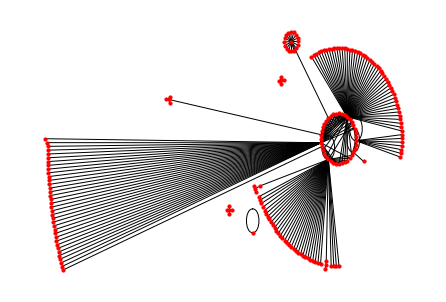

In [7]:
G = nx.Graph()

proteins = {}
interactome = Interactome()
interactions = []

#data.head(3)

for i in range(len(data)):
    p1 = data.iloc[i,0].split(':')[1]
    p2 = data.iloc[i,1].split(':')[1]
    (p1, p2) = (p1, p2) if p1 > p2 else (p2, p1)
    interactions.append((p1, p2))
    G.add_edge(p1, p2, count=0, physical=0)
    interactome.add_interaction(p1, p2)
pos = nx.spring_layout(G, k=0.2) # layout : calcule la position des noeuds
#nx.draw(G, pos, with_labels=False, node_size=5)
nx.draw(G, pos=nx.nx_agraph.graphviz_layout(G, prog='circo'), with_labels=False, node_size=10, node_color='red')

### Faire du diamètre des noeuds une fonction du nombre de partenaires protéiques.

#### G.nodes() : itération des noeuds toujours dans le même ordre
for node in G.nodes():
    print(len(G.edges(node)))

if G.has_edge('a', 'b'): # objet utilisé pour construire le graphe
    G['a']['b']['value'] = 10
else:
    G.add_edge('a','b',value=5)

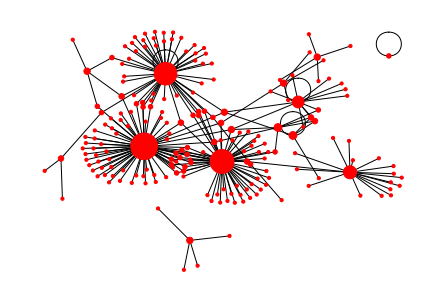

In [8]:
nx.draw(G, pos, with_labels=False, node_color=['red' for n in G.nodes()],
        node_size=[d[1]*10 for d in G.degree()]
)

### Faire de la largeur des arêtes une fonction du nombre d'experiences (lignes MITAB) detectant cette interaction

In [9]:
for prot1, prot2 in interactions:
    if not G.has_edge(prot1, prot2):
        G[prot1][prot2]['count'] = 0
    G[prot1][prot2]['count'] += 1

for i in range(len(data)):
    prot1, prot2 = interactions[i][0], interactions[i][1]
    if not G.has_edge(prot1, prot2):
        G[prot1][prot2]['physical'] = 0
    if is_interaction_physical(data, i):
        #print(data.iloc[i,0:2], is_interaction_physical(data, i))
        G[prot1][prot2]['physical'] += 1

#print(interactions[:3])

In [10]:
#print([G.get_edge_data(*e)['count'] for e in G.edges])

In [11]:
#print([G.get_edge_data(*e) for e in G.edges])

In [12]:
#[G.get_edge_data(*e) for e in G.edges]

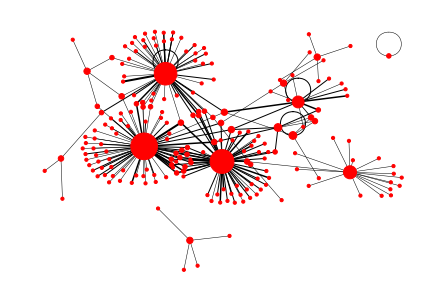

In [13]:
nx.draw(G, pos, with_labels=False, node_color=['red' for n in G.nodes()],
        node_size=[d[1]*10 for d in G.degree()],
        width=[G.get_edge_data(*e)['count']/2 for e in G.edges],
)

### Colorier les arêtes soutenues par au moins une interaction de type physique entre proteines.

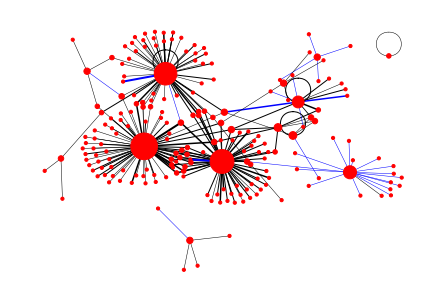

In [14]:
nx.draw(G, pos, with_labels=False, node_color=['red' for n in G.nodes()],
        node_size=[d[1]*10 for d in G.degree()],
        #node_size=[1 for d in G.degree()],
        width=[G.get_edge_data(*e)['count']/2 for e in G.edges],
        #width=[1 for e in G.edges],
        edge_color=['blue' if G.get_edge_data(*e)['physical'] > 0 else 'black' for e in G.edges]
)

## Croisement des données d'interaction et de protéomique

En utilisant les données d'abondance du fichier `TCL_wt1.tsv`, essayez de modifier le rendu du réseau pour:
* colorier dans une couleur spécifique uniquement les protéines surabondantes dans l'expérience.
* N'afficher que les noeuds des protéines mesurées dans l'experience.
* Utiliser une échelle de couleur continue fonction de l'abondance pour colorier les noeuds.
* colorier les protéines appartenant à des classes GO communes.

In [15]:
#datatcl[datatcl['Accession'] == 'P76231']['Log2 Corrected Abundance Ratio']
#data[data[11] == 'psi-mi:"MI:0915"(physical association)']

In [16]:
# Log2 Corrected Abundance Ratio : taille / couleur des cercles
# éventuellement combiner l'info avec autre chose

In [17]:
n_in = 0
n_out = 0
for node in G.nodes:
    abundance = get_tcl_abundance(node)
    if abundance > -99:
        n_in += 1
    else:
        n_out += 1

In [18]:
print(n_in, n_out)

144 60


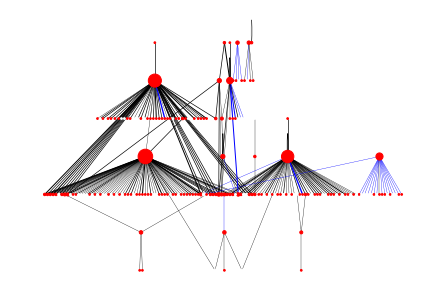

In [23]:
# >= 0 : rouge
# -999 < x < 0
# <= -999 : gris

# ['red' if get_tcl_abundance(node) > -99 else 'blue' for node in G.nodes]

abundances = [get_tcl_abundance(node) for node in G.nodes]
col = ['red' if abundance > -999 else 'white' for abundance in abundances]

nx.draw(G,
        pos=nx.nx_agraph.graphviz_layout(G, prog='dot'),
        with_labels=False,
        node_color=col,
        node_size=[d[1]*3 for d in G.degree()],
        width=[G.get_edge_data(*e)['count']/3 for e in G.edges],
        edge_color=['blue' if G.get_edge_data(*e)['physical'] > 0 else 'black' for e in G.edges]
)

# 204 noeuds, 60 pas dans l'expérience TCL

In [24]:
# MITAB : 14 abondantes

In [25]:
real_abundances = []
for abundance in abundances:
    if abundance > -999:
        real_abundances.append(abundance)

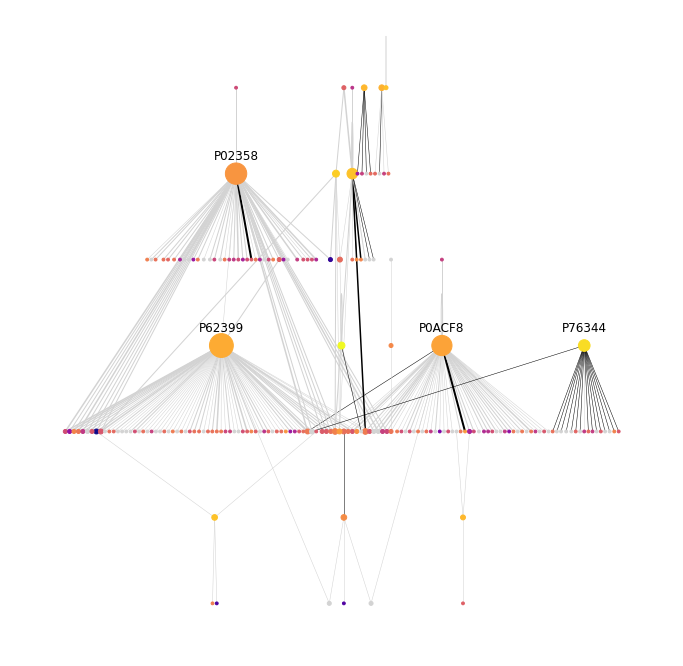

In [62]:
palette = 'plasma'
cmap = plt.get_cmap(palette)
cNorm = matplotlib.colors.Normalize(vmin = min(real_abundances), vmax = max(real_abundances))
cNormLog = matplotlib.colors.LogNorm(vmin = min(real_abundances), vmax = max(real_abundances))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=plt.get_cmap(palette))

colors = [scalarMap.to_rgba(ab) for ab in abundances]

labels = {}
for node in G.nodes:
    labels[node] = node if G.degree[node] > 15 else ''

# graphviz_layout prog : dot, neato, fdp, sfdp, circo, twopi

fig, ax = plt.subplots(figsize=(12,12))
pos = nx.nx_agraph.graphviz_layout(G, prog='dot')

pos2 = dict(pos)
for node in pos2:
    pos2[node] = pos2[node][0], pos2[node][1] + 15

nx.draw_networkx_labels(G, pos2, labels)
nx.draw(G,
        pos,
        with_labels=False,
        node_color=[colors[i] if abundances[i] > -999 else 'lightgrey' for i in range(len(abundances))],
        node_size=[d[1]*8 for d in G.degree()],
        width=[G.get_edge_data(*e)['count']/2 for e in G.edges],
        edge_color=['black' if G.get_edge_data(*e)['physical'] > 0 else 'lightgrey' for e in G.edges]
)

plt.savefig('Graph.png', format='png')
plt.savefig('Graph.svg', format='svg')

plt.show()

In [50]:
# GO_node_1 = o._bk.BP.getByName('ion transport')
# GO_node_2 = o._bk.BP.getById('GO:0006811')
# goNode.eTag contient tous les id de prots comprenant ce terme

In [53]:
for node in pos:
    pos[node] = pos[node][0], pos[node][1] + 20

<generator object <genexpr> at 0x000002B0160AFB30>
P0A6X3
P02358
P0AFG8
P0ACF8
P0A6Y1
P62399
P36659
P30871
P06996
P0A8J8
P37095
P0A910
P69820
P15082
P0A8T7
P68739
P0A717
P0DMC7
P0ABH9
P0AA25
P02931
P76344
P0AAB8
P37765
P0A7E9
P64467
P0ABT2
P0A7Z4
P0ACG1
P0A850
P0A6W5
P0C054
P0A8V2
P76506
P0A6F5
P60785
P0A9Q1
P09996
P61175
EBI-6860602
P0AC65
P06610
P06612
P10408
P60624
P0A6Y8
P06710
P0A6X7
P0A912
P0A9K3
P15977
P37903
P0AGJ5
P03018
P0A8I5
P0A9Y6
P0ABB4
P0A6G7
P0A6Q6
P77768
P0A9X4
P0ABD5
P02924
P06616
P69791
P0A9A6
P60723
P16528
P69811
P0A6Z3
P75970
P0A8F8
P42630
P0ADZ0
P0A776
P75829
P77656
P42592
P13036
P27848
P05055
P0A940
P0ACN4
P0A6A8
P36979
P76502
P25522
P0AFG0
P00490
P69411
P25539
P32694
P0ACF0
P27253
P21599
P06971
P0AFZ3
P21499
P0AB74
P0A8V6
P0ACF4
P0A9K9
P0AAS7
P0AB28
P0AC69
P0AD21
P0AEU7
Q46793
P0A905
P0A8A0
P0A8G0
EBI-9130824
P0AG24
P37052
P0A799
P0A7V0
P0AF26
P0A707
P63228
P0AA39
P05847
P0ADH5
P32162
P08622
P0A814
P0ABS8
P0AC75
P33224
P0AGE0
P0DMC9
Q46864
P0A8M6
P0A6U3
P13024
P